# Setup

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    models,
    layers,
    optimizers,
    losses,
    regularizers,
    models,
    applications
)
import tensorflow_hub as hub

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

os.environ['TFHUB_MODEL_LAOD_FORMAT'] = 'COMPRESSED'

## Read the data

In [3]:
def read_and_decode(filename, reshape_dims):
    img = tf.io.read_file(filename) # Read the file
    img = tf.image.decode_jpeg(img, channels=3) # convert the compressed string to a 3d uint8 tensor
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, reshape_dims)

def decode_csv(csv_row):
    record_defaults = ['path', 'flower']
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

## Helper Functions

In [4]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);
    ax[flower].axis('off')

# Pretrained Embeddings

## Pretrained Model

In [5]:
huburl = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4'
hub.KerasLayer(
    handle=huburl,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    trainable=False,
    name='mobilenet_embedding')


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-03-08 19:05:34.760550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 19:05:34.760679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Transfer Learning

In [6]:
def train_and_evaluate(batch_size=32,
                       lrate=1e-3,
                       l1=0.,
                       l2=0.,
                       num_hidden=16):
    
    huburl = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
    
    regularizer = regularizers.l1_l2(l1, l2)
    
    train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
                     map(decode_csv, num_parallel_calls=AUTOTUNE)).batch(batch_size)
    eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
                    map(decode_csv, num_parallel_calls=AUTOTUNE)).batch(batch_size)
    
    list_layers = [
        hub.KerasLayer(
            handle=huburl,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            trainable=False,
            name='mobilenet_embedding'),
        layers.Dense(num_hidden,
                     kernel_regularizer=regularizer,
                     activation='elu',
                     kernel_initializer='he_normal',
                     name='dense_hidden'),
        layers.Dense(len(CLASS_NAMES),
                     kernel_regularizer=regularizer,
                     activation='softmax',
                     name='flower_prob')
    ]
    
    model = tf.keras.Sequential(list_layers, name='flower_classification')
    model.compile(optimizer=optimizers.Adam(learning_rate=lrate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
    training_plot(['loss', 'accuracy'], history)
    return model


Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5


2022-03-08 19:05:38.936846: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 19:05:40.469728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-08 19:05:40.631282: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


    104/Unknown - 193s 2s/step - loss: 0.5868 - accuracy: 0.7794

2022-03-08 19:08:52.094253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 219s 2s/step - loss: 0.5868 - accuracy: 0.7794 - val_loss: 0.3779 - val_accuracy: 0.8730
Epoch 2/5
104/104 [==============================] - 228s 2s/step - loss: 0.2765 - accuracy: 0.9064 - val_loss: 0.3525 - val_accuracy: 0.8865
Epoch 3/5
104/104 [==============================] - 217s 2s/step - loss: 0.1981 - accuracy: 0.9394 - val_loss: 0.3433 - val_accuracy: 0.8892
Epoch 4/5
104/104 [==============================] - 204s 2s/step - loss: 0.1481 - accuracy: 0.9561 - val_loss: 0.3434 - val_accuracy: 0.8946
Epoch 5/5
104/104 [==============================] - 218s 2s/step - loss: 0.1115 - accuracy: 0.9712 - val_loss: 0.3512 - val_accuracy: 0.9000


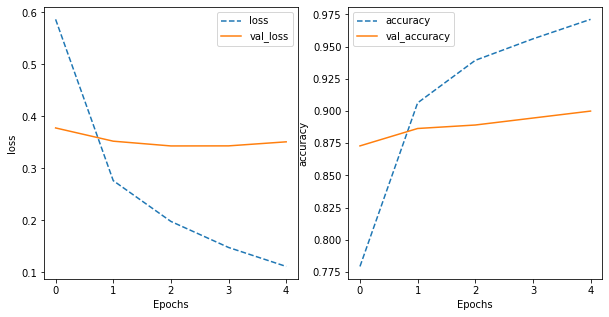

In [7]:
model = train_and_evaluate()

In [8]:
# Loading the same model from Keras

pretrained_model = applications.MobileNetV2(
    weights='imagenet', 
    include_top=False,
    input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
pretrained_model.trainable = False

keras_model = tf.keras.Sequential([
    layers.Lambda(
        lambda data: applications.mobilenet.preprocess_input(
            tf.cast(data, tf.float32)),
        input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]),
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='elu', kernel_initializer='he_normal'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

2022-03-08 19:23:47.448569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


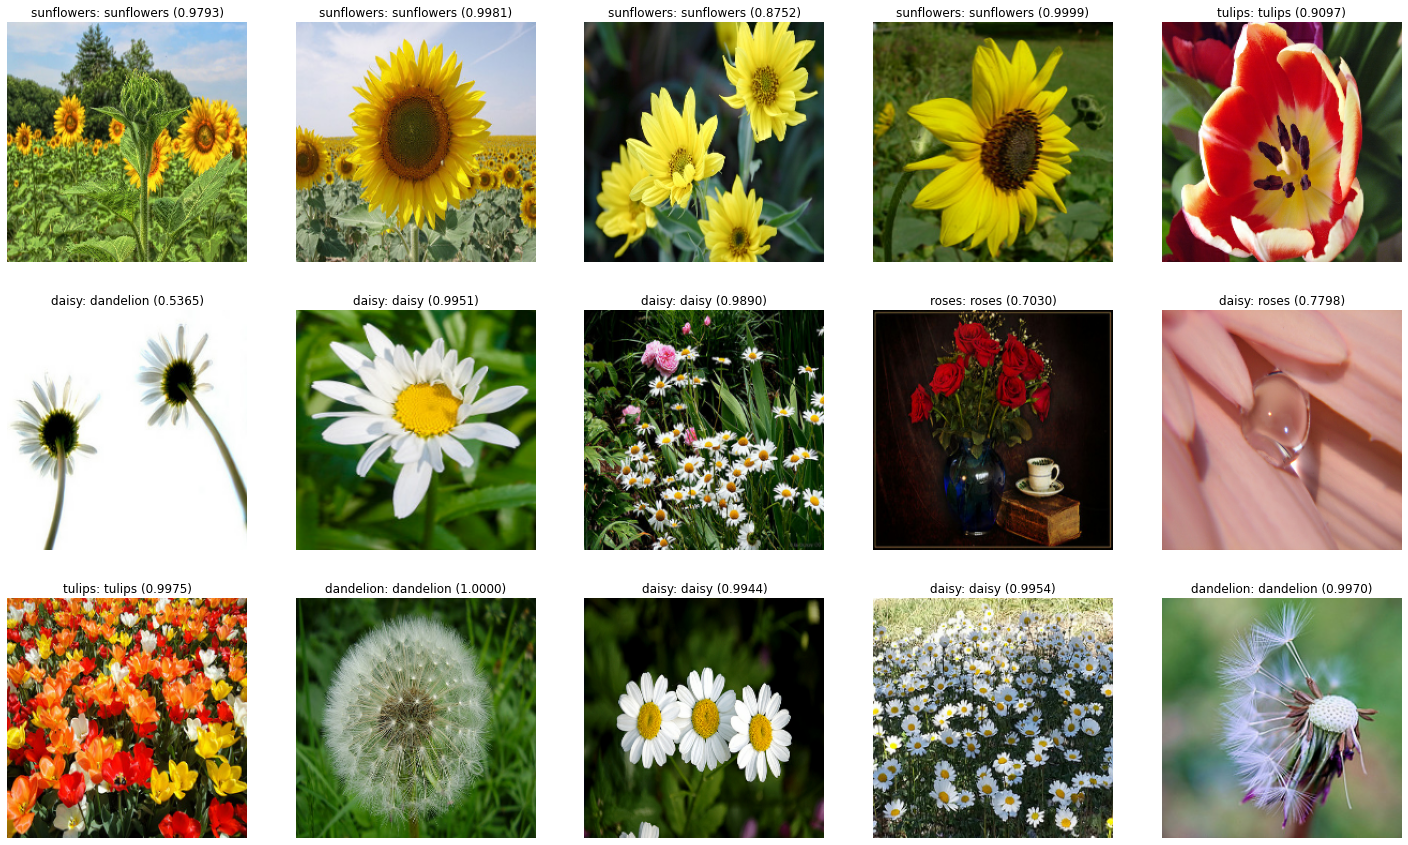

In [9]:
plot_predictions(model, "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")

# Convolutional Networks

## AlexNet

In [10]:
# Implementing AlexNet with keras
model = models.Sequential([
    layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]),
    layers.Conv2D(96, 11, strides=4, activation='relu'),
    layers.Conv2D(256, 4, activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(384, 3, activation='relu'),
    layers.MaxPool2D(strides=2),
    layers.Conv2D(384, 3, activation='relu'),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPool2D(strides=2),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name='AlexNet')

# The Quest for Depth

## SqueezeNet

In [13]:
# The Fire module is a parallel module

def fire(x, squeeze, expand):
    y = layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = layers.BatchNormalization()(y)
    y1 = layers.Conv2D(filters=expand // 2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = layers.BatchNormalization()(y1)
    y3 = layers.Conv2D(filters=expand // 2, kernel_size=1, activation='relu', padding='same')(y)
    y3 = layers.BatchNormalization()(y3)
    return layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

In [15]:
# Let's implement a custom 24-layer SqueezeNet

x = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
y = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
y = layers.BatchNormalization()(y)
y = fire_module(16, 32)(y)
y = layers.MaxPooling2D()(y)
y = fire_module(48, 96)(y)
y = layers.MaxPool2D()(y)
y = fire_module(64, 128)(y)
y = fire_module(80, 160)(y)
y = fire_module(96, 192)(y)
y = layers.MaxPool2D()(y)
y = fire_module(112, 224)(y)
y = fire_module(128, 256)(y)
y = fire_module(160, 320)(y)
y = layers.MaxPool2D()(y)
y = fire_module(192, 384)(y)
y = fire_module(224, 448)(y)
y = layers.MaxPool2D()(y)
y = fire_module(256, 512)(y)
y = layers.GlobalAvgPool2D()(y)
y = layers.Dense(len(CLASS_NAMES), activation='softmax')(y)

model = tf.keras.Model(x, y)

# Modular Architectures

# Neural Architecture Search Designs

# Beyond Convolution: The Transformer Architecture

# Choosing a Model